# Diffusion Models

Diffusion models create new data that resembles their training set through a repeated cycle of applying and then removing noise.

They have been explored as an alternate to other generative frameworks, such as GANs and VAEs.

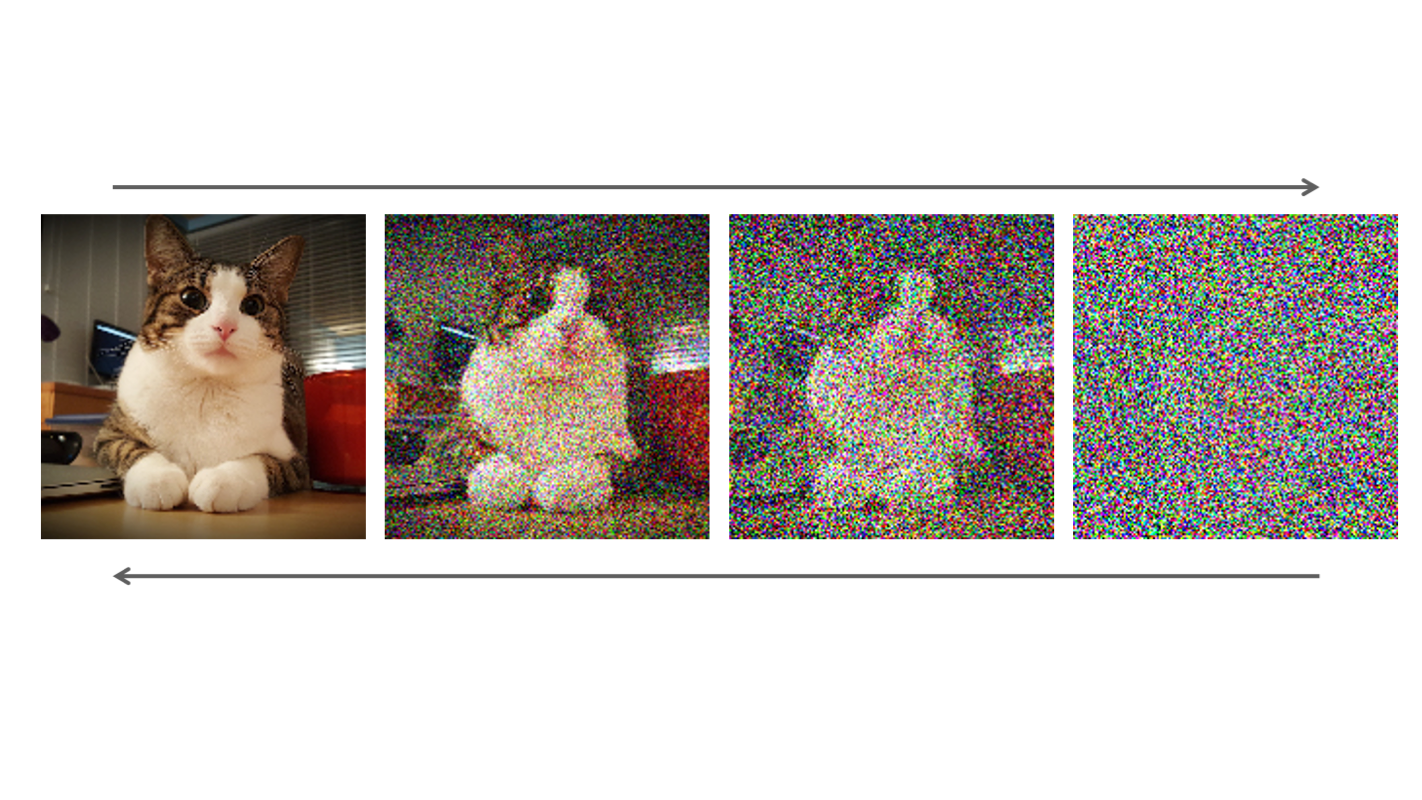

Image taken from [here](https://developer.nvidia.com/blog/improving-diffusion-models-as-an-alternative-to-gans-part-2/)


Diffusion models have evolved significantly from their traditional roots in image processing, where they were primarily employed for tasks like noise reduction and image restoration. These early methods relied on hand-crafted mathematical models to describe the diffusion process. However, the advent of deep learning marked a transformative shift. By leveraging neural networks, diffusion models can now learn the intricacies of the diffusion process directly from data, unlocking their potential for a vast array of applications, particularly in the generative modeling domain.

## Setup

This notebook runs a compact DDPM-style diffusion model on MNIST.

In [ ]:
!pip install -q torch torchvision tqdm torchinfo

In [ ]:
import math
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from tqdm.notebook import tqdm


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed: int = 0):
    random.seed(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Forward (noising) and Reverse (denoising)

Diffusion models learn to denoise images through two stages.

1. Forward (noising) process: We start with a clean image x₀ (for example, a digit from MNIST). Then, step by step, we add a small amount of Gaussian noise. If we keep doing this for many steps, the image eventually becomes indistinguishable from pure noise. This process is fixed and does not involve learning.

2. Reverse (denoising) process: We train a neural network to undo this corruption. Given a noisy image x_t and the time step t, the model tries to predict the noise that was added. By gradually removing noise step by step, the model learns to transform random noise into a meaningful image.

This makes diffusion models conceptually similar to VAEs (probabilistic) and GANs (image generation), but their training is much more stable: instead of a complicated adversarial game, we just use a simple regression loss.

**Key equation (DDPM):**

* Forward (closed form): $ x_t = \sqrt{\bar{α_t}} * x_0 + \sqrt{1 - \bar{α_t}} * ϵ $
* Training target: predict `eps` (the noise) given $x\_t$ and $t$.


Below we’ll try this in practice: take an MNIST digit, pick a timestep, and generate the corresponding noisy image.

In [ ]:
# Sample x_t from x0 using the closed-form
def make_beta_schedule(T, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, T)

set_seed(42)

T = 1000
betas = make_beta_schedule(T).to(DEVICE)
alphas = 1. - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# Load one MNIST sample
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist = datasets.MNIST(root='data', train=True, download=True, transform=transform)
x0, _ = mnist[0]
x0 = x0.to(DEVICE).unsqueeze(0)  # add batch dimension

# Forward process: sample x_t from q(x_t | x_0)
t = 50  # example timestep
sqrt_alpha_bar = alpha_bars[t].sqrt().view(1, 1, 1, 1)
sqrt_one_minus_alpha_bar = (1 - alpha_bars[t]).sqrt().view(1, 1, 1, 1)

eps = torch.randn_like(x0)
xt = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * eps

# Visualize
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title('x₀')
plt.imshow((x0.cpu().squeeze() * 0.5 + 0.5), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'x_t (t={t})')
plt.imshow((xt.cpu().squeeze() * 0.5 + 0.5), cmap='gray')
plt.axis('off')

plt.show()

## Small UNet-like network

The model needs to know the current timestep `t`. We'll embed `t` to a vector (sinusoidal embedding) and feed it into a small convolutional U-Net-ish model. This technique transforms the raw timestep into a rich, continuous representation that captures both absolute and relative temporal information. For this example we use a compact model: a sequence of conv blocks with residual connections.

In [ ]:
# Sinusoidal timestep embedding
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=device) * -(math.log(10000.0) / (half_dim - 1)))
        emb = t[:, None].float() * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

# Small conv block
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.act = nn.GELU()
        self.norm = nn.GroupNorm(1, out_ch)
        self.time_mlp = nn.Linear(time_emb_dim, out_ch) if time_emb_dim else None

        # 1x1 conv for residual if needed
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb=None):
        h = self.act(self.norm(self.conv1(x)))
        if t_emb is not None:
            h = h + self.time_mlp(t_emb)[:, :, None, None]
        h = self.conv2(h)
        return self.act(h + self.res_conv(x))

# Tiny UNet-like model for MNIST
class TinyUNet(nn.Module):
    def __init__(self, ch=32, emb_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(emb_dim),
            nn.Linear(emb_dim, emb_dim),
            nn.GELU()
        )

        self.init = nn.Conv2d(1, ch, 3, padding=1)
        self.down1 = Block(ch, ch, emb_dim)
        self.mid = Block(ch, ch, emb_dim)
        self.up1 = Block(ch, ch, emb_dim)
        self.final = nn.Conv2d(ch, 1, 1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        h = self.init(x)
        h = self.down1(h, t_emb)
        h = self.mid(h, t_emb)
        h = self.up1(h, t_emb)
        return self.final(h)


torchinfo.summary(TinyUNet(), input_data=(torch.zeros(1,1,28,28), torch.zeros(1,dtype=torch.long)))

## Training objective (predicting noise)

We'll train the model to predict the noise `eps` using MSE loss: `loss = || eps - eps_theta(x_t, t) ||^2`. The training step samples a random `t` for each batch and uses the closed form to compute `x_t`.

In [ ]:
# Precompute schedules as tensors on device
T = 1000
betas = make_beta_schedule(T).to(DEVICE)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# Sample x_t and eps given x0 and t
def q_sample(x0, t, noise=None):
    # x0: [B,C,H,W], t: [B]
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_alpha_bar = alpha_bars[t].sqrt().view(-1,1,1,1)
    sqrt_one_minus_alpha_bar = (1 - alpha_bars[t]).sqrt().view(-1,1,1,1)
    return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

# Reverse denoising loop (simple ancestral sampling)
@torch.no_grad()
def sample(model, n=16):
    model.eval()
    x = torch.randn(n, 1, 28, 28, device=DEVICE)
    for i in reversed(range(T)):
        t = torch.full((n,), i, device=DEVICE, dtype=torch.long)
        eps_theta = model(x, t)

        alpha = alphas[t].view(-1, 1, 1, 1)
        alpha_bar = alpha_bars[t].view(-1, 1, 1, 1)
        beta = betas[t].view(-1, 1, 1, 1)

        # mean (μθ) term from Algorithm 2
        mean = (1 / torch.sqrt(alpha)) * (
            x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * eps_theta
        )

        # sample z ~ N(0, I) if t > 0
        if i > 0:
            z = torch.randn_like(x)
            sigma_t = torch.sqrt(beta)
            x = mean + sigma_t * z
        else:
            x = mean

    x = torch.clamp(x, -1.0, 1.0)
    model.train()
    return x

## Visualise outputs

In [ ]:
def simple_visualize(model, dataloader, n=8):
    """Simple grid comparison"""
    model.eval()

    # Get real samples
    real_batch, _ = next(iter(dataloader))
    real_batch = real_batch[:n].to(DEVICE)

    # Generate samples
    with torch.no_grad():
        generated = sample(model, n=n)

    # Create combined grid
    real_grid = make_grid((real_batch.cpu() + 1) / 2, nrow=n)
    gen_grid = make_grid((generated.cpu() + 1) / 2, nrow=n)

    # Plot side by side
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(real_grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title('Real MNIST Digits')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(gen_grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title('Generated Digits')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    model.train()

# Coursework


## Task 1:

In diffusion models, images are gradually corrupted with Gaussian noise. Your task is to implement a function that adds noise to the images given a time step.
Fill in the missing code in the add_noise() function and generate some noised images, almost to the point where the original image is unrecognisable.
**Report**

*   Include the clean image, the noised image and the noise itself.



In [ ]:
def add_noise(x: torch.Tensor, t: torch.Tensor, sqrt_alphas_cumprod: torch.Tensor, sqrt_one_minus_alphas_cumprod: torch.Tensor):
    """
    Add noise to input images according to the diffusion process.

    Args:
        x: torch.Tensor
            Original clean images (batch_size, channels, height, width).
        t: torch.Tensor
            Time steps for each image in the batch (batch_size,).
        sqrt_alphas_cumprod: torch.Tensor
            Precomputed square root of cumulative product of alphas.
        sqrt_one_minus_alphas_cumprod: torch.Tensor
            Precomputed square root of (1 - cumulative product of alphas).

    Returns:
        x_noisy: torch.Tensor
            The noisy images at time step t.
        noise: torch.Tensor
            The Gaussian noise that was added.
    """

## Task 2

Now it's time to train the model.

Steps:

- Loop over the dataset.
- For each batch:
  - Sample random time steps.
  - Add noise to the images.
  - Predict the noise with your model.
  - Compute and backpropagate the loss.
- Track the training loss to monitor progress.

**Report**

*   Include your code and figures of the training loss.
